<a href="https://colab.research.google.com/github/Aneesh2000/AmazonReviewSentimentAnalysis/blob/main/Amazon_pro_rev_senti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#NLP Packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# PAckages for models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# packages for avoiding warning data. 
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

**Reading and doing basic data analysis of data**


In [ ]:
amazon_reviews = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
amazon_reviews.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
amazon_reviews.shape

(10000, 9)

**Looking for number of words per** **review**

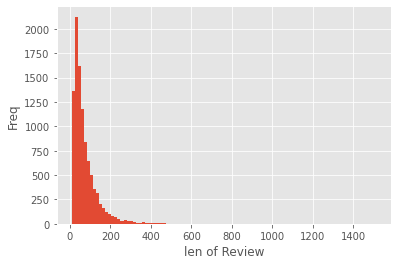

data in words_per_review


0        48
1        31
2        94
3        41
4        27
       ... 
9995     74
9996     80
9997    174
9998     24
9999    198
Name: Text, Length: 10000, dtype: int64

In [ ]:
words_per_review = amazon_reviews.Text.apply(lambda x:len(x.split()))
words_per_review.hist(bins = 100)
plt.xlabel("len of Review")
plt.ylabel("Freq")
plt.show()
print("data in words_per_review")
words_per_review

In [ ]:
print("Average_words_per_review: ",words_per_review.mean())

Average_words_per_review:  76.2309


**Distribution of the ratings-column.**

In [ ]:
percent_val = 100*amazon_reviews['Score'].value_counts()/len(amazon_reviews)
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

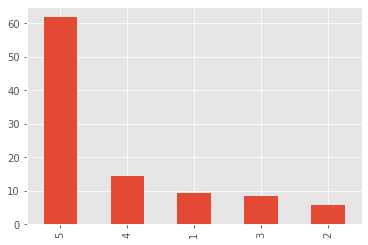

In [ ]:
percent_val.plot.bar()
plt.show()

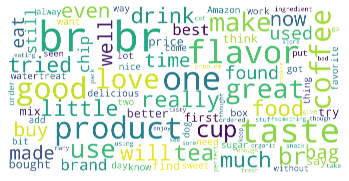

In [ ]:
word_cloud_text = ''.join(amazon_reviews['Text'])
wordcloud = WordCloud(max_font_size=100,max_words=100,background_color="white",
                      scale = 10, width=800,height=400).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

Standardizing the ratings for sentiment analysis (5 mts)

In [ ]:
# Mapping the ratings
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3,1,0)

## Removing neutral reviews 
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

# Printing the counts of each class
amazon_reviews['Sentiment_rating'].value_counts()

1    7616
0    1522
Name: Sentiment_rating, dtype: int64

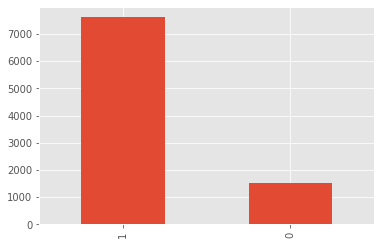

In [ ]:
amazon_reviews.Sentiment_rating.value_counts().plot.bar()
plt.show()

Pre-processing
1. Converting words to lower/upper case

In [ ]:
amazon_reviews['reviews_text_new'] = amazon_reviews['Text'].str.lower()


In [ ]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')
# Word tokenization example:
word_tokenize("DPhi Bootcamp rules. It is awesome :D")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['DPhi', 'Bootcamp', 'rules', '.', 'It', 'is', 'awesome', ':', 'D']

In [ ]:
# For reviews not converted to lowe case
token_lists = [word_tokenize(each) for each in amazon_reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lowe case
token_lists_lower = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  27899
Number of unique tokens now:  22865


2. Removing special characters

In [ ]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = amazon_reviews['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '§',
 '®'}

In [ ]:
review_backup = amazon_reviews['reviews_text_new'].copy()
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [ ]:
print("- Old Review -")
print(review_backup.values[5])
print("\n- New Review -")
print(amazon_reviews['reviews_text_new'][5])

- Old Review -
i got a wild hair for taffy and ordered this five pound bag. the taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. my only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). between me, my kids, and my husband, this lasted only two weeks! i would recommend this brand of taffy -- it was a delightful treat.

- New Review -
i got a wild hair for taffy and ordered this five pound bag  the taffy was all very enjoyable with many flavors  watermelon  root beer  melon  peppermint  grape  etc  my only complaint is there was a bit too much red black licorice flavored pieces  just not my particular favorites  between me  my kids  and my husband  this lasted only two weeks  i would recommend this brand of taffy   it was a delightful treat 


In [ ]:
token_lists = [word_tokenize(each) for each in amazon_reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  27899
Number of unique tokens now:  18039


3. Stopwords and high/low frequency words

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [ ]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

example of removing stopwords:

In [ ]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = amazon_reviews['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


In [ ]:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_reviews['reviews_text_nonstop'] = amazon_reviews['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
amazon_reviews[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,..."
1,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,this is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy..."
3,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,great taffy at a great price there was a wid...,"[great, taffy, great, price, wide, assortment,..."
...,...,...
9995,we switched from the advance similac to the or...,"[switched, advance, similac, organic, product,..."
9996,like the bad reviews say the organic formula ...,"[like, bad, reviews, say, organic, formula, co..."
9997,i wanted to solely breastfeed but was unable t...,"[wanted, solely, breastfeed, unable, keep, sup..."
9998,i love the fact that i can get this delieved t...,"[love, fact, get, delieved, house, delievy, ch..."


4. Stemming & lemmatization

In [ ]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


Bag-of-words

In [ ]:
# The following code creates a word-document matrix.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(amazon_reviews['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,00,000,0003,000kwh,002,008,0100,0174,02,03,0303,032,03510,04,042608460503,0472066978,04830,05,06,062,07,0738551856,09,090,0g,0mg,0xk6hzpjrkaed855hewp,0z,10,100,1000,100ml,100s,100x,101,103,105,108,10g,10lb,...,zany,zap,zapp,zareba,zeal,zealand,zen,zero,zest,zesty,zevia,zhena,zico,ziggies,zilch,zin,zinc,zinfandels,zing,zinging,zip,ziploc,ziplock,zipper,zippy,zito,ziwipeak,zn,zojirushi,zola,zomg,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


use this to create a bag of words from the reviews, excluding the noise words we identified earlier:



In [ ]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words=noise_words, # List of stopwords
                             ngram_range=(1,1)) # number of n-grams

bow_data = bow_counts.fit_transform(amazon_reviews['reviews_text_new'])

In [ ]:
bow_data.head()


NameError: ignored

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    amazon_reviews['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [ ]:
y_test_bow.value_counts()/y_test_bow.shape[0]


1    0.847921
0    0.152079
Name: Sentiment_rating, dtype: float64

**Applying logistic regression:**

Let's train the model on our training data and run the resulting model on our test data:

In [ ]:
### Training the model 
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow) # Class prediction

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.9526854219948849


In [ ]:
############### RandomForest Classifier applied. 
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_bow,y_train_bow)

y_pred=rfc.predict(X_test_bow)

print("F1 score: ",f1_score(y_test_bow,y_pred))

F1 score:  0.9306097927305497


modifying the set of features in the model to include bigrams, trigrams, and 4-grams:

In [ ]:
### Changes with respect to the previous code
### 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram, 3-gram, and 4-gram)
### 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amazon_reviews.reviews_text_new)

In [ ]:
# Notice the increase in features with inclusion of n-grams
bow_data

<9138x1261413 sparse matrix of type '<class 'numpy.int64'>'
	with 2530528 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    amazon_reviews['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

In [ ]:
#### LOGISTIC REGRESSION
# Defining and training the model
lr_model_all_new = LogisticRegression(max_iter = 200)
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))

F1 score:  0.9541745134965474


In [ ]:
rfc_new = RandomForestClassifier(n_estimators=100)
rfc_new.fit(X_train_bow,y_train_bow)

y_pred=rfc_new.predict(X_test_bow)

print("F1 score: ",f1_score(y_test_bow,y_pred))

F1 score:  0.9278659084106555


The F1-score has jumped slightly for logistic regression. This is an example of what simple hyperparameter tuning and input feature modification can do to the overall performance. We can even get interpretable features from this in terms of what contributed the most to positive and negative sentiment:

In [ ]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # get all the n-gram feature names
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

,words,weights
448809,great,1.327825
305794,delicious,0.952226
810997,perfect,0.838265
438773,good,0.831878
1023733,the best,0.820454
358331,excellent,0.820369
171393,best,0.792752
639088,love,0.783723
709971,nice,0.769280
930961,smooth,0.637403


In [ ]:
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews


,words,weights
1241695,worst,-0.542737
1175374,very disappointed,-0.558068
1206112,were,-0.564819
874505,return,-0.568158
143979,away,-0.573385
959625,stick,-0.585494
144964,awful,-0.593931
1193585,waste,-0.612413
317336,disappointing,-0.613688
982546,t,-0.674788


**TF-IDF model**

re-featurize our original set of reviews based on TF-IDF and split the resulting features into train and test sets:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(amazon_reviews['reviews_text_new'])

In [ ]:
tfidf_data


<9138x18039 sparse matrix of type '<class 'numpy.float64'>'
	with 493450 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            amazon_reviews['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

Applying logistic regression to TF-IDF features

In [ ]:
### Setting up the model class
lr_model_tf_idf = LogisticRegression()

## Training the model 
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluating the model
print("F1 score: ",f1_score(y_test_tfidf, test_pred_lr_all))

F1 score:  0.9396341463414635


Applying RandomForest classifier to TF-IDF features

In [ ]:
rfc_tf = RandomForestClassifier(n_estimators=100)
rfc_tf.fit(X_train_tfidf,y_train_tfidf)

y_pred=rfc_tf.predict(X_test_tfidf)

print("F1 score: ",f1_score(y_test_tfidf,y_pred))

F1 score:  0.9278659084106555
